# CC Scheme

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from obspy import UTCDateTime, read_inventory
import xcorr

In [2]:
%matplotlib notebook

In [3]:
client = xcorr.Client(sds_root='/Users/psmets/Documents/Research/_data/WaveformArchive')

<IPython.core.display.Javascript object>


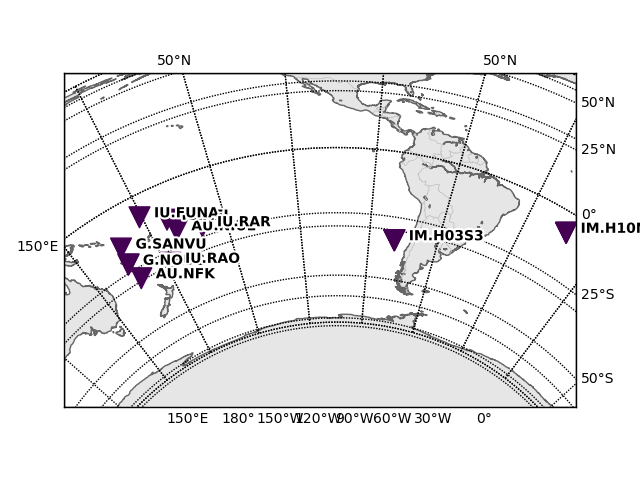

In [4]:
inv = read_inventory('Monowai.xml')
fig = inv.plot(color=0., projection='local')

## Get waveforms

In [5]:
EDH = client.get_waveforms(
    receiver = 'IM.H03S1..EDH', 
    time = pd.to_datetime('2015-01-15T12:00'), 
    verbose = True,
)

Get waveforms for IM.H03S1..EDH from 2015-01-14 23:59:00 until 2015-01-16 00:01:00
Get waveform data for 2015-01-14T00:00:00.000000Z.
Samples in day = 21600000, samples in stream = 21600001, max gaps = 75000.
Waveform data for 2015-01-14T00:00:00.000000Z loaded from archive.
Get waveform data for 2015-01-15T00:00:00.000000Z.
Samples in day = 21600000, samples in stream = 21600001, max gaps = 75000.
Waveform data for 2015-01-15T00:00:00.000000Z loaded from archive.
Get waveform data for 2015-01-16T00:00:00.000000Z.
Samples in day = 21600000, samples in stream = 21600001, max gaps = 75000.
Waveform data for 2015-01-16T00:00:00.000000Z loaded from archive.
Get waveform data for 2015-01-17T00:00:00.000000Z.
Samples in day = 21600000, samples in stream = 21600001, max gaps = 75000.
Waveform data for 2015-01-17T00:00:00.000000Z loaded from archive.


<IPython.core.display.Javascript object>


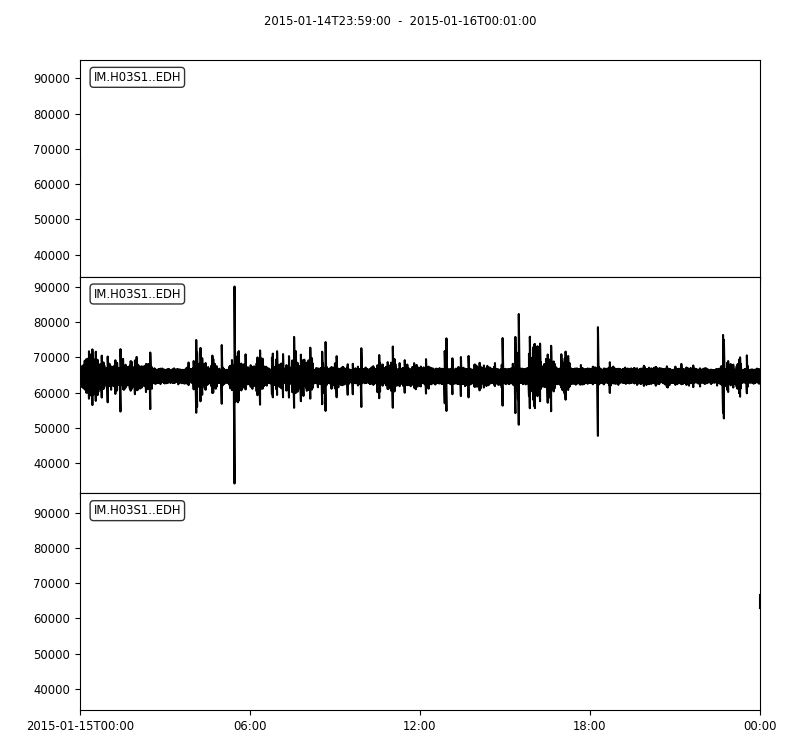

In [6]:
EDH.plot()

## Preprocess settings

In [7]:
# stream preprocess operations (sequential!)
preprocess = {
    'BHZ': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('filter', { 'type': 'highpass', 'freq': 3. }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20 }),
        ('filter', { 'type': 'lowpass', 'freq': 20. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
        # ('running_rms', {}),
    ],
    'BHR': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('rotate', {'method':'->ZNE'}),
        ('rotate', {'method':'NE->RT', 'back_azimuth':250.39 }),
        ('select', {'channel':'BHR'}),
        ('filter', { 'type': 'highpass', 'freq': 3. }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20 }),
        ('filter', { 'type': 'lowpass', 'freq': 20. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
        # ('running_rms', {}),
    ],
    'EDH': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_sensitivity', {}),
        # ('remove_response', {}),
        ('filter', { 'type': 'bandpass', 'freqmin': 3., 'freqmax': 20. }),
        ('decimate', { 'factor': 5 }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
        # ('running_rms', {}),
    ],
}

In [9]:
EDH = client.get_preprocessed_waveforms(
    receiver = 'IM.H10N1..EDH', 
    time = pd.to_datetime('2015-01-01T12:00'), 
    preprocess = preprocess,
    inventory = inv,
    verbose = True,
)

5 Trace(s) in Stream:
IM.H10N1..EDH | 2014-12-31T23:59:00.000000Z - 2015-01-01T00:00:00.000000Z | 250.0 Hz, 15001 samples
IM.H10N1..EDH | 2015-01-01T00:00:00.000000Z - 2015-01-01T00:00:00.000000Z | 250.0 Hz, 1 samples
IM.H10N1..EDH | 2015-01-01T00:00:00.000000Z - 2015-01-01T00:00:00.000000Z | 250.0 Hz, 1 samples
IM.H10N1..EDH | 2015-01-01T00:00:00.000000Z - 2015-01-02T00:00:00.000000Z | 250.0 Hz, 21600001 samples
IM.H10N1..EDH | 2015-01-02T00:00:00.000000Z - 2015-01-02T00:01:00.000000Z | 250.0 Hz, 15001 samples
merge :  {'method': 1, 'fill_value': 'interpolate', 'interpolation_samples': 0}
filter :  {'type': 'highpass', 'freq': 0.05}
detrend :  {'type': 'demean'}
remove_sensitivity :  {'inventory': <obspy.core.inventory.inventory.Inventory object at 0x1159cba10>}
filter :  {'type': 'bandpass', 'freqmin': 3.0, 'freqmax': 20.0}
decimate :  {'factor': 5}
trim :  {'starttime': UTCDateTime(2015, 1, 1, 0, 0), 'endtime': UTCDateTime(2015, 1, 2, 0, 0)}
detrend :  {'type': 'demean'}
taper :  {'

/Users/psmets/miniconda3/envs/ccf/lib/python3.7/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


<IPython.core.display.Javascript object>


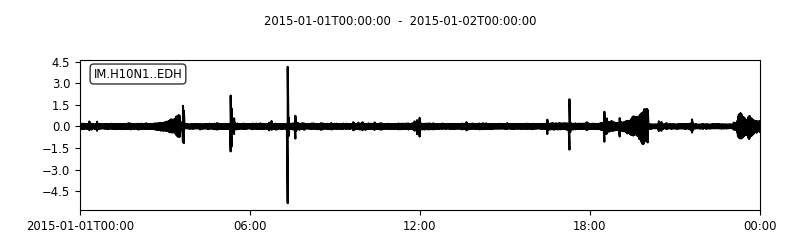

In [10]:
EDH.plot()

In [12]:
BHZ = client.get_preprocessed_waveforms(
    receiver = 'IU.RAR.10.BHZ', 
    time = pd.to_datetime('2015-01-15T12:00'), 
    preprocess = preprocess,
    inventory = inv,
    verbose = True,
)

3 Trace(s) in Stream:
IU.RAR.10.BHZ | 2015-01-14T23:58:59.994500Z - 2015-01-14T23:59:59.994500Z | 40.0 Hz, 2401 samples
IU.RAR.10.BHZ | 2015-01-15T00:00:00.019500Z - 2015-01-15T23:59:59.994500Z | 40.0 Hz, 3456000 samples
IU.RAR.10.BHZ | 2015-01-16T00:00:00.019500Z - 2015-01-16T00:00:59.994500Z | 40.0 Hz, 2400 samples
merge :  {'method': 1, 'fill_value': 'interpolate', 'interpolation_samples': 0}
filter :  {'type': 'highpass', 'freq': 0.05}
detrend :  {'type': 'demean'}
remove_response :  {'output': 'VEL', 'inventory': <obspy.core.inventory.inventory.Inventory object at 0x1159cba10>}
filter :  {'type': 'highpass', 'freq': 3.0}
interpolate :  {'sampling_rate': 50, 'method': 'lanczos', 'a': 20}
filter :  {'type': 'lowpass', 'freq': 20.0}
trim :  {'starttime': UTCDateTime(2015, 1, 15, 0, 0), 'endtime': UTCDateTime(2015, 1, 16, 0, 0)}
detrend :  {'type': 'demean'}
taper :  {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.0}


/Users/psmets/miniconda3/envs/ccf/lib/python3.7/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


<IPython.core.display.Javascript object>


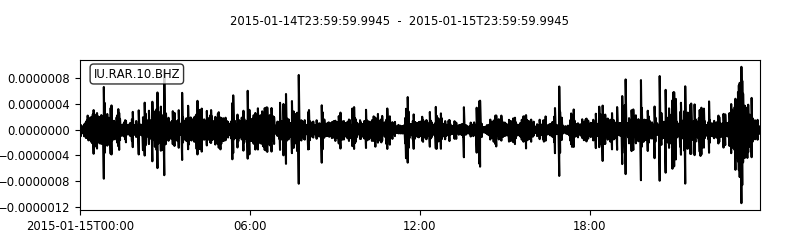

In [13]:
BHZ.plot()

In [20]:
BHR = client.get_preprocessed_waveforms(
    receiver = 'IU.RAR.10.BHR', 
    time = pd.to_datetime('2016-01-15T12:00'), 
    preprocess = preprocess,
    inventory = inv,
    verbose = True,
    debug = True,
)

Get waveforms for IU.RAR.10.BH1 from 2016-01-14 23:59:00 until 2016-01-16 00:01:00
Get waveform data for 2016-01-14T00:00:00.000000Z.
Samples in day = 3456000, samples in stream = 3456000, max gaps = 12000.
Waveform data for 2016-01-14T00:00:00.000000Z loaded from archive.
Get waveform data for 2016-01-15T00:00:00.000000Z.
Samples in day = 3456000, samples in stream = 3456000, max gaps = 12000.
Waveform data for 2016-01-15T00:00:00.000000Z loaded from archive.
Get waveform data for 2016-01-16T00:00:00.000000Z.
Samples in day = 3456000, samples in stream = 3456000, max gaps = 12000.
Waveform data for 2016-01-16T00:00:00.000000Z loaded from archive.
Get waveform data for 2016-01-17T00:00:00.000000Z.
Samples in day = 3456000, samples in stream = 3456000, max gaps = 12000.
Waveform data for 2016-01-17T00:00:00.000000Z loaded from archive.
Get waveforms for IU.RAR.10.BH2 from 2016-01-14 23:59:00 until 2016-01-16 00:01:00
Get waveform data for 2016-01-14T00:00:00.000000Z.
Samples in day = 34

/Users/psmets/miniconda3/envs/ccf/lib/python3.7/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


<IPython.core.display.Javascript object>


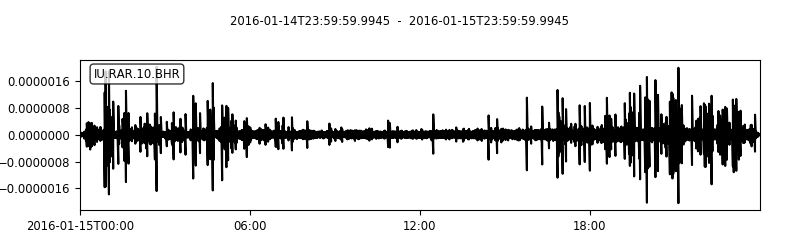

In [21]:
BHR.plot()

## Preprocessed pair stream

In [16]:
pair = client.get_pair_preprocessed_waveforms(
    pair = 'IM.H03S1..EDH-IU.RAR.10.BHZ',
    time = pd.to_datetime('2015-01-15T12:00'), 
    preprocess = preprocess,
    inventory = inv,
    verbose = True
)

3 Trace(s) in Stream:
IM.H03S1..EDH | 2015-01-14T23:59:00.000000Z - 2015-01-15T00:00:00.000000Z | 250.0 Hz, 15001 samples
IM.H03S1..EDH | 2015-01-15T00:00:00.000000Z - 2015-01-16T00:00:00.000000Z | 250.0 Hz, 21600001 samples
IM.H03S1..EDH | 2015-01-16T00:00:00.000000Z - 2015-01-16T00:01:00.000000Z | 250.0 Hz, 15001 samples
merge :  {'method': 1, 'fill_value': 'interpolate', 'interpolation_samples': 0}
filter :  {'type': 'highpass', 'freq': 0.05}
detrend :  {'type': 'demean'}
remove_sensitivity :  {'inventory': <obspy.core.inventory.inventory.Inventory object at 0x1159cba10>}
filter :  {'type': 'bandpass', 'freqmin': 3.0, 'freqmax': 20.0}
decimate :  {'factor': 5}
trim :  {'starttime': UTCDateTime(2015, 1, 15, 0, 0), 'endtime': UTCDateTime(2015, 1, 16, 0, 0)}
detrend :  {'type': 'demean'}
taper :  {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.0}


/Users/psmets/miniconda3/envs/ccf/lib/python3.7/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


3 Trace(s) in Stream:
IU.RAR.10.BHZ | 2015-01-14T23:58:59.994500Z - 2015-01-14T23:59:59.994500Z | 40.0 Hz, 2401 samples
IU.RAR.10.BHZ | 2015-01-15T00:00:00.019500Z - 2015-01-15T23:59:59.994500Z | 40.0 Hz, 3456000 samples
IU.RAR.10.BHZ | 2015-01-16T00:00:00.019500Z - 2015-01-16T00:00:59.994500Z | 40.0 Hz, 2400 samples
merge :  {'method': 1, 'fill_value': 'interpolate', 'interpolation_samples': 0}
filter :  {'type': 'highpass', 'freq': 0.05}
detrend :  {'type': 'demean'}
remove_response :  {'output': 'VEL', 'inventory': <obspy.core.inventory.inventory.Inventory object at 0x1159cba10>}
filter :  {'type': 'highpass', 'freq': 3.0}
interpolate :  {'sampling_rate': 50, 'method': 'lanczos', 'a': 20}
filter :  {'type': 'lowpass', 'freq': 20.0}
trim :  {'starttime': UTCDateTime(2015, 1, 15, 0, 0), 'endtime': UTCDateTime(2015, 1, 16, 0, 0)}
detrend :  {'type': 'demean'}
taper :  {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.0}


<IPython.core.display.Javascript object>


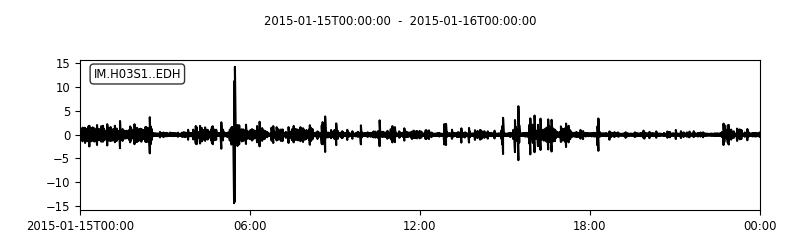

In [17]:
pair[0].plot()

<IPython.core.display.Javascript object>


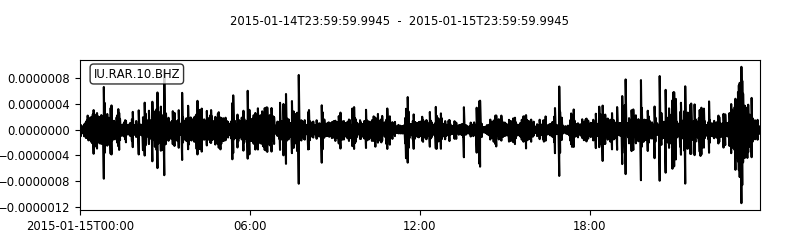

In [18]:
pair[1].plot()

## Hash

In [ ]:
%%timeit
xcorr.util.hasher.hash_Stream(pair)

In [ ]:
xcorr.util.hasher.hash(pair)